In [31]:
import sys
import torch
import global_variables as gv
import sys
import numpy as np
import matplotlib.pyplot as plt
import configparser
from FACTS_Modules.Model import model_factory
from FACTS_Modules.util import string2dtype_array
from FACTS_Modules.TADA import MakeGestScore
from facts_visualizations import single_trial_plots, multi_trial_plots
import os 
import pdb
import seaborn as sns

In [2]:
def simulator(theta):
    ini='DesignA_pert.ini'
    gFile='GesturalScores/KimetalOnlinepert2.G'
    config = configparser.ConfigParser()
    config.read(ini)

    # Replace the parameter value from ini file
    #pdb.set_trace()
    try:
        if theta.numel() > 1:
            config['SensoryNoise']['Somato_sensor_scale'] = str(theta[0].item())
        else:
            #pdb.set_trace()
            config['SensoryNoise']['Somato_sensor_scale'] = str(theta.item())
    except:
        pdb.set_trace()

    model = model_factory(config)
    #pdb.set_trace()
    if 'MultTrials' in config.sections(): 
        ntrials = int(config['MultTrials']['ntrials'])
        target_noise= float(config['MultTrials']['Target_noise'])
    else: 
        ntrials = 1
        target_noise = 0

    #pdb.set_trace()
    gest_name = gFile.split('/')[-1]
    np.random.seed(100)
    GestScore, ART, ms_frm, last_frm = MakeGestScore(gFile,target_noise)
    
    # initialize vectors to monitor position at each timestep
    a_record = np.empty([ntrials,last_frm,gv.a_dim])
    x_record = np.empty([ntrials,last_frm,gv.x_dim])
    formant_record = np.empty([ntrials,last_frm,3])
    shift_record = np.empty([ntrials,last_frm,3])
    a_tilde_record = np.empty([ntrials,last_frm,gv.a_dim])
    a_dot_record = np.empty([ntrials,last_frm,gv.a_dim])
    a_dotdot_record = np.empty([ntrials,last_frm,gv.a_dim])
    predict_formant_record = np.empty([ntrials,last_frm,3])

    #Check if catch trials (no perturbation) are specified in the config file
    if 'CatchTrials' in config.keys():
        catch_trials = string2dtype_array(config['CatchTrials']['catch_trials'], dtype='int')
        catch_types = string2dtype_array(config['CatchTrials']['catch_types'], dtype='int')
        if len(catch_trials) != len(catch_types):
            raise Exception("Catch trial and catch type lengths not matching, please check the config file.")
    else: catch_trials = np.array([])

    #pdb.set_trace()

    #Run FACTS for each trial
    for trial in range(ntrials):
        print("trial:", trial)
        #Gestural score (task)
        GestScore, ART, ms_frm, last_frm = MakeGestScore(gFile,target_noise)         #this is similar with MakeGest in the matlab version

        # initial condition
        x_tilde = string2dtype_array(config['InitialCondition']['x_tilde_init'],'float')
        a_tilde = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        a_actual = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        model.artic_sfc_law.reset_prejb() #save the initial artic-to-task model.

        if trial in catch_trials: catch = catch_types[np.where(catch_trials==trial)[0][0]]
        else: catch = False
        print("catch:", catch)
        
        for i_frm in range(last_frm):
            #model function runs FACTS by each frame
            x_tilde, a_tilde, a_actual, formants, formants_shifted, adotdot, y_hat = model.run_one_timestep(x_tilde, a_tilde, a_actual, GestScore, ART, ms_frm, i_frm, trial, catch)
            
            #save the FACTS results
            a_record[trial, i_frm,:] = a_actual[0:gv.a_dim]
            a_tilde_record[trial, i_frm,:] = a_tilde[0:gv.a_dim]
            a_dot_record[trial, i_frm,:] = a_tilde[gv.a_dim:]
            x_record[trial, i_frm,:] = x_tilde[0:gv.x_dim]
            formant_record[trial, i_frm,:] = formants
            predict_formant_record[trial, i_frm,:] = y_hat
            shift_record[trial, i_frm, :] = formants_shifted
            a_dotdot_record[trial, i_frm,:] = adotdot
    #pdb.set_trace()
    return formant_record[:,:,0].squeeze() 


## Run an example trails of FACTS, just to make sure out data look okay later

In [43]:
# Print an example trial 
example = simulator(torch.tensor([0.000737]))

Artic SFC Law Model Type:  lwpr
[ 5.32 17.59 25.89]
[-3999999.00062613   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271]
Task State Estimator Model Type:  lwpr
trial: 0
catch: False


## Load observed data from Inez's study

(1, 116)
(116,)
(16, 729)


(1, 116)
(116,)
(1, 729)


Text(0, 0.5, 'F1 HZ')

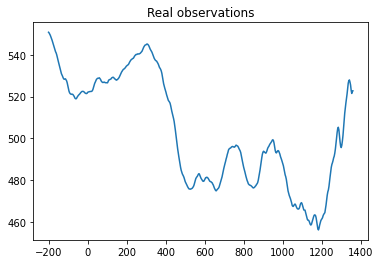

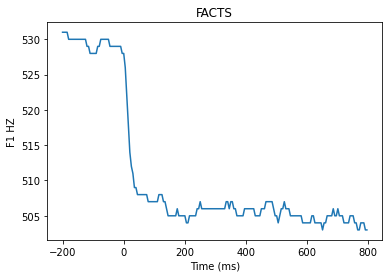

In [50]:
# Import real observed data
import scipy.io

trial_cells_mat = scipy.io.loadmat('sbi_resources/formant_pert_data.mat')
trial_cells = trial_cells_mat['trial_cells']
trial_cells_times = scipy.io.loadmat('sbi_resources/formant_pert_data_times.mat')['trial_time_cells']

# Alter the trial_cells so that they center to where FACTS centers
trial_cells = trial_cells + 531
print(trial_cells.shape)
print(trial_cells[0].shape)
print(trial_cells[0][0].shape) # 
print("\n")
print(trial_cells_times.shape)
print(trial_cells_times[0].shape)
print(trial_cells_times[0][0].shape)

plt.plot(trial_cells_times[0][0][0,:]*1000, trial_cells[0][0][0,:])
plt.title('Real observations')

# Now realign so that 
plt.figure()
plt.title('FACTS')
example_x = (np.arange(len(example))*5)-200
plt.plot(example_x,example)
plt.xlabel('Time (ms)')
plt.ylabel('F1 HZ')

## Perform SBI using FACTS and Inez's data

In [4]:
from sbi.inference import infer
from sbi import utils as utils
# import facts_for_SBI

# import your simulator, define your prior over the parameters
prior_mean = 0.000737
prior_min= [0.0001]
prior_mmax = [0.001] 
# prior = torch.distributions.Uniform(torch.as_tensor(mmin), torch.as_tensor(mmax) )
prior = utils.torchutils.BoxUniform(torch.as_tensor(prior_min), torch.as_tensor(prior_mmax) )
parameter_posterior = infer(simulator, prior, method='SNPE', num_simulations=10)





Artic SFC Law Model Type:  lwpr
[ 5.32 17.59 25.89]
[-3999999.00062613   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271]
Task State Estimator Model Type:  lwpr
trial: 0
catch: False
Artic SFC Law Model Type:  lwpr
[ 5.32 17.59 25.89]
[-3999999.00062613   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66

Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

Artic SFC Law Model Type:  lwpr
[ 5.32 17.59 25.89]
[-3999999.00062613   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271]
Task State Estimator Model Type:  lwpr
trial: 0
catch: False
Artic SFC Law Model Type:  lwpr
[ 5.32 17.59 25.89]
[-3999999.00062613   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66

/Users/alvincepongos/opt/anaconda3/envs/facts_sbi_env/lib/python3.6/site-packages/sbi/neural_nets/flow.py:108: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn(f"In one-dimensional output space, this flow is limited to Gaussians")


Neural network successfully converged after 21 epochs.


In [6]:
samples = parameter_posterior.sample((200,), x=observation[0])
log_probability = parameter_posterior.log_prob(samples, x=observation[0])
out = utils.pairplot(samples, limits=[[-5,5],[-5,5]], fig_size=(6,6), upper='kde', diag='kde')

NameError: name 'observation' is not defined

In [55]:
n_observations = 5
observation = torch.tensor([3., -1.5])[None] + 0.5*torch.randn(n_observations, 2)

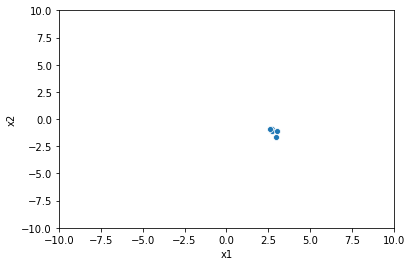

In [60]:
import seaborn as sns
sns.scatterplot(x=observation[:, 0], y=observation[:, 1])
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()